## Importing the Required Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
folder_path = '/content/gdrive/MyDrive/DF-DL/'
os.listdir(folder_path)

['dataset',
 'trained-model',
 '.ipynb_checkpoints',
 'CDCS',
 'CAPSTONE',
 'dataset-deepfake',
 'le.pickle']

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator


## Loading Images from the Disk

In [ ]:
# Global Variables for later use

IMAGE_SIZE = 128
BATCH_SIZE = 32
CHANNELS = 3

In [ ]:
import tensorflow
print(tensorflow.__version__)

2.17.0


In [ ]:
def read_and_preprocess(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR) # reading the image
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE)) # resizing it to 128*128
    img = np.array(img, dtype='float32') # convert its datatype so that it could be normalized
    img = img/255 # normalization (now every pixel is in the range of 0 and 1)
    return img

In [ ]:
labels = ['real', 'fake']

X = [] # To store images
y = [] # To store labels

# labels -
# 0 - Real
# 1 - Fake
image_path = '/content/gdrive/MyDrive/DF-DL/dataset/' # path containing image samples

In [ ]:
for folder in os.scandir(image_path):
    for entry in os.scandir(image_path + folder.name):

        X.append(read_and_preprocess(image_path + folder.name + '/' + entry.name))

        if folder.name[0]=='r':
            y.append(0) # real
        else:
            y.append(1) # fake

In [ ]:
X = np.array(X)
X.shape

(1289, 128, 128, 3)

In [ ]:
y = np.array(y)
y.shape


(1289,)

## Exploring the Dataset

<BarContainer object of 2 artists>

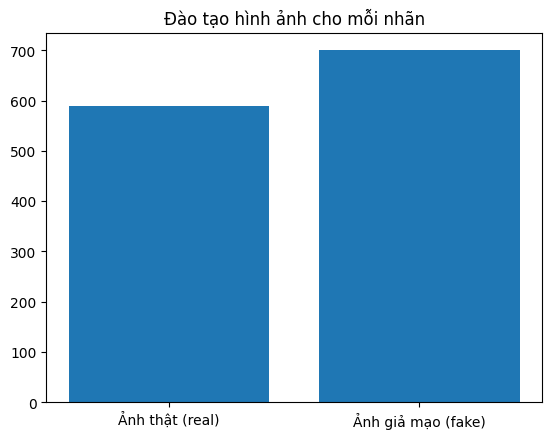

In [ ]:
real_count = len(y[y==0])
fake_count = len(y[y==1])

plt.title("Đào tạo hình ảnh cho mỗi nhãn")
plt.bar(["Ảnh thật (real)", "Ảnh giả mạo (fake)"],[real_count, fake_count])

# We have more samples of Fake Images than Real Images

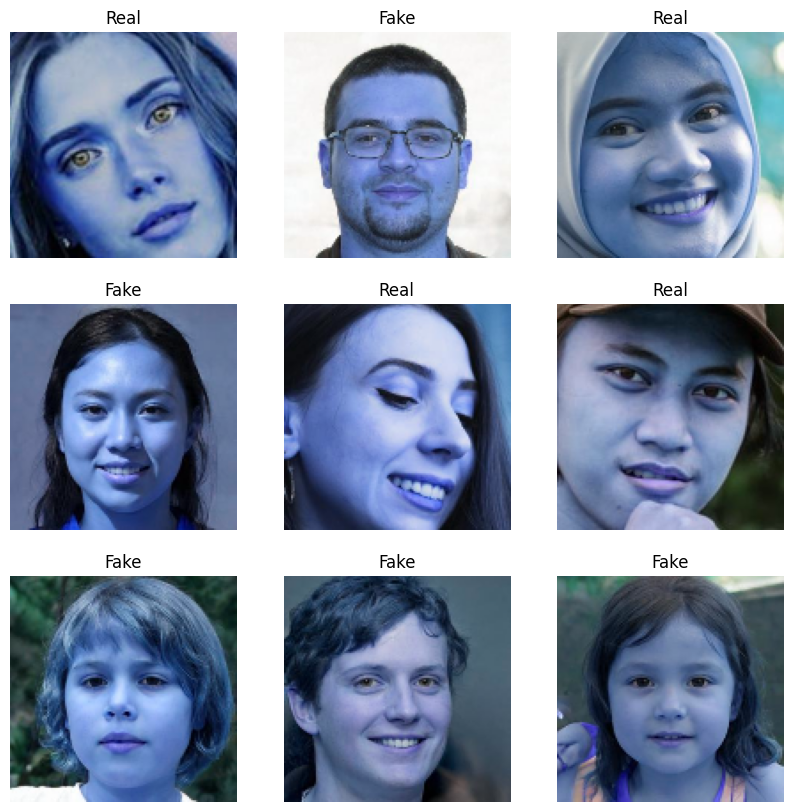

In [ ]:
import matplotlib.pyplot as plt

# Hiển thị ngẫu nhiên 9 hình ảnh từ tập dữ liệu
plt.figure(figsize=(10, 10))
for i in range(9):
    idx = np.random.randint(0, len(X))
    img = X[idx]
    label = 'Real' if y[idx] == 0 else 'Fake'
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
plt.show()

## Splitting the dataset

We will take -
- 80% data for training our model
- 10% data for validation purpose
- 10% data for test purpose

In [ ]:
from sklearn.model_selection import train_test_split

# We have splitted our data in a way that -
# 1. The samples are shuffled
# 2. The ratio of each class is maintained (stratify)
# 3. We get same samples every time we split our data (random state)

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  shuffle=True,
                                                  stratify=y,
                                                  random_state=123)

In [ ]:
X_test, X_val, y_test, y_val = train_test_split(X_val, y_val,
                                                  test_size=0.5,
                                                  shuffle=True,
                                                  stratify=y_val,
                                                  random_state=123)

In [ ]:
X_train.shape

(1036, 128, 128, 3)

In [ ]:
# we are using 129 images for validating our model
X_val.shape

(129, 128, 128, 3)

In [ ]:
# we are using 129 images for testing our model
X_test.shape

(129, 128, 128, 3)

In [ ]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = tf.keras.Sequential([
    Conv2D(filters=32, kernel_size=(2,2), activation='relu', input_shape=input_shape),
    MaxPooling2D((4,4)),

    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D((3,3)),
    Dropout(0.3), # for regularization

    Conv2D(filters=64, kernel_size=(4,4), activation='relu', padding='same'),
    Conv2D(filters=128, kernel_size=(5,5), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Dropout(0.4),

    Conv2D(filters=128, kernel_size=(5,5), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Dropout(0.5),

    Flatten(), # flattening for feeding into ANN
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(n_classes, activation='softmax')
])



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# compile the model
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='Adam', metrics= ["accuracy"])

In [ ]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="/content/gdrive/MyDrive/DF-DL/trained-model/fakevsreal_weights.keras", verbose=1, save_best_only=True)


In [ ]:
history = model.fit(X_train, y_train, epochs = 40, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, shuffle=True, callbacks=[earlystopping, checkpointer])


Epoch 1/40
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.4566 - loss: 0.7005
Epoch 1: val_loss improved from inf to 0.68398, saving model to /content/gdrive/MyDrive/DF-DL/trained-model/fakevsreal_weights.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 17s 271ms/step - accuracy: 0.4581 - loss: 0.7003 - val_accuracy: 0.5426 - val_loss: 0.6840
Epoch 2/40
29/33 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5394 - loss: 0.6782
Epoch 2: val_loss did not improve from 0.68398
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5442 - loss: 0.6768 - val_accuracy: 0.5116 - val_loss: 0.6914
Epoch 3/40
30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6450 - loss: 0.6545
Epoch 3: val_loss improved from 0.68398 to 0.57567, saving model to /content/gdrive/MyDrive/DF-DL/trained-model/fakevsreal_weights.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6511 - loss: 0.6492 - val_accuracy: 0.7364 - val_loss: 0.5757
Epoch 4/40
30/33 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8026 - loss:

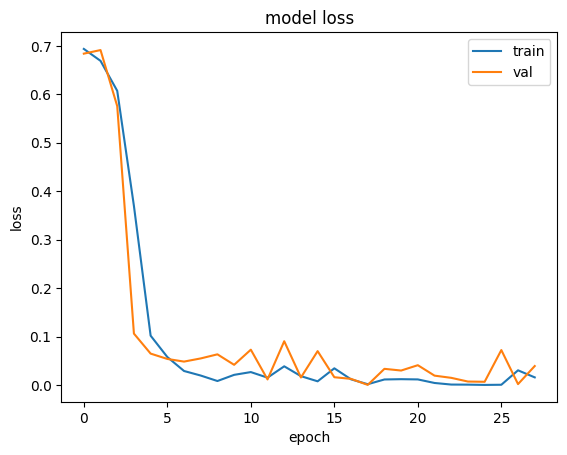

In [ ]:
# The is how training loss and validation loss varied during training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

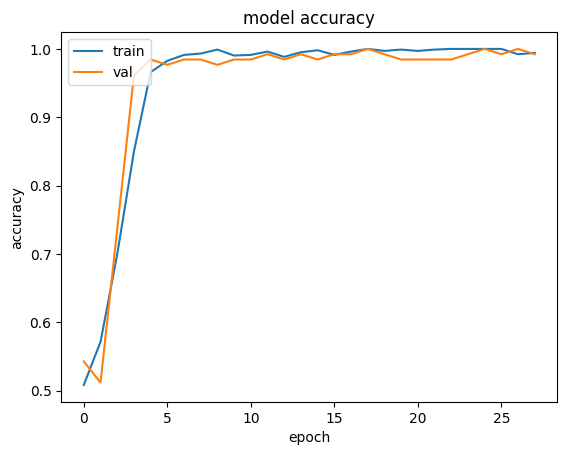

In [ ]:
# The is how training accuracy and validation accuracy varied during training
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
# save the model architecture to json file for future use

model_json = model.to_json()
with open("fakevsreal_model.json","w") as json_file:
  json_file.write(model_json)

## Evaluating the Saved Model Performance

In [ ]:
# Load pretrained model (best saved one)
with open('fakevsreal_model.json', 'r') as json_file:
    json_savedModel= json_file.read()

# load the model weights
model = tf.keras.models.model_from_json(json_savedModel)
model.load_weights('/content/gdrive/MyDrive/DF-DL/trained-model/fakevsreal_weights.keras')
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='Adam', metrics= ["accuracy"])

In [ ]:
predictions = model.predict(X_test)

# Obtain the predicted class from the model prediction
predict = []

for i in predictions:
  predict.append(np.argmax(i))

predict = np.asarray(predict)

# Obtain the accuracy of the model
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, predict)
accuracy

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step


1.0

<Axes: >

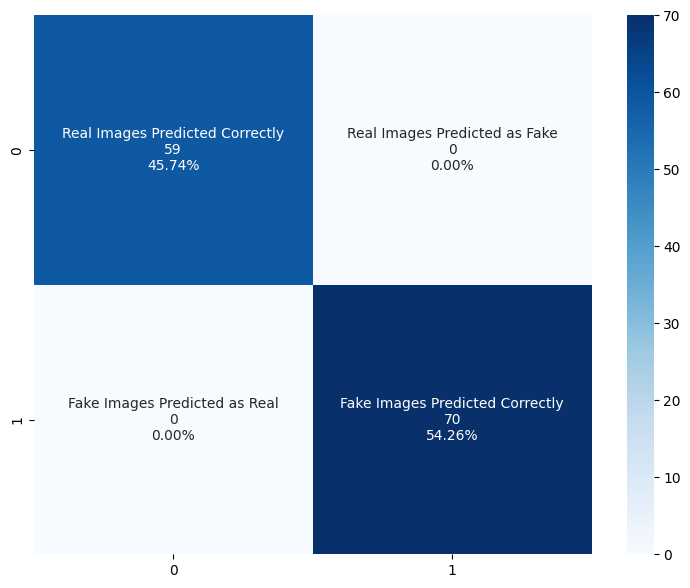

In [ ]:
# plot the confusion matrix
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_test, predict)
plt.figure(figsize = (9,7))

group_names = ['Real Images Predicted Correctly','Real Images Predicted as Fake','Fake Images Predicted as Real','Fake Images Predicted Correctly']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_test, predict)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        59
           1       1.00      1.00      1.00        70

    accuracy                           1.00       129
   macro avg       1.00      1.00      1.00       129
weighted avg       1.00      1.00      1.00       129

